In [1]:
import requests # to handle requests
import pandas as pd # for data analsysis
import numpy as np # to handle data in a vectorized manner
import itertools
import os
os.environ["PROJ_LIB"] = "C:\\Users\\ShibashisDatta\\Anaconda3\\Library\\share"; #fixr
from mpl_toolkits.basemap import Basemap

llon=-140
ulon=-50
llat=40
ulat=65

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
    
#tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#import altair as alt
#alt.renderers.enable('notebook') # show and interact ith plots in jupyter notebook

## foursqare api credential

In [2]:
CLIENT_ID = 'Q00JD5YBC4OFCGXP5N5JRCSEGLTVCTK2FBVCXS5RHC4H43JN' # your Foursquare ID
CLIENT_SECRET = 'Q1HLN3L3HWRXCW3DWW4J2ZKQCYTVKF5NHWAVLGC2YMFXHIEC' # your Foursquare Secret
VERSION = '20191106'
LIMIT =30
print('Your credentails:')
print('Foursquare_ID: ' + CLIENT_ID)
RADIUS = 10000 # 4 Km
NO_OF_VENUES = 100
print('Foursquare_Secret:' + CLIENT_SECRET)
search_query = 'Restaurant','Fast Food Restaurant'

Your credentails:
Foursquare_ID: Q00JD5YBC4OFCGXP5N5JRCSEGLTVCTK2FBVCXS5RHC4H43JN
Foursquare_Secret:Q1HLN3L3HWRXCW3DWW4J2ZKQCYTVKF5NHWAVLGC2YMFXHIEC


In [3]:
# define the city and get its latitude & longitude 
city = 'Kolkata'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(city,timeout=10)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

22.5677459 88.3476023


We define the get_category_type method to get the correct category for each venue.

In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
We will set the radius as 4 Kilometers.
The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [5]:
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        latitude, 
                                                                        longitude, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))


Total 100 venues fetched within a total radius of 10.0 Km
Total 91 venues fetched within a total radius of 10.0 Km

Total 191 venues fetched


#### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

The query will be the name of the venue.
The start defines from what offset we want to start, so we'll keep it at 0.
The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
We will supply the latitude and longitude values.
We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [6]:
headers = {'user-key': 'acf0169c4cb58a7b3fba977b41d17f1a'}
venues_information = []

#for index, row in foursquare_venues.iterrows():
limit = 180
for index, row in itertools.islice(foursquare_venues.iterrows(), limit):
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])



Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

#### Checking data types

In [7]:
# first use info() to get types of each column
zomato_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 7 columns):
venue            180 non-null object
latitude         180 non-null object
longitude        180 non-null object
price_for_two    180 non-null float64
price_range      180 non-null float64
rating           180 non-null object
address          178 non-null object
dtypes: float64(2), object(5)
memory usage: 9.9+ KB


#### Converting data types in numeric

In [8]:
zomato_venues[['latitude', 'longitude']] = zomato_venues[['latitude', 'longitude']].apply(pd.to_numeric) 
print(zomato_venues.dtypes) 

venue             object
latitude         float64
longitude        float64
price_for_two    float64
price_range      float64
rating            object
address           object
dtype: object


### Plot Foursquare data -- showing city map

In [9]:
kol_map_fs = folium.Map(location = [latitude, longitude], zoom_start = 11)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(kol_map_fs)  

kol_map_fs.save("Kolkata_Venues_Foursquare.html")
kol_map_fs

### Plot Zomato data cityview

In [10]:
kol_map_zomato = folium.Map(location = [latitude, longitude], zoom_start = 11)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(kol_map_zomato)  

kol_map_zomato.save("Kolkata_Venues_Zomato.html")
kol_map_zomato

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [11]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [12]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [13]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Lalit Great Eastern Hotel,Hotel,22.5680,88.3500,The Tea Lounge - The Lalit Great Eastern,22.5679,88.3502,1500.0,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",-0.0001,0.0002
1,Blue & Beyond,Pub,22.5591,88.3533,Blue And Beyond,22.5591,88.3532,1600.0,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",0.0000,-0.0001
2,Peter Cat,Indian Restaurant,22.5524,88.3525,Peter Cat,22.5524,88.3525,1000.0,3.0,4.3,"18A, Park Street, Park Street Area, Kolkata",0.0000,0.0000
3,The Blue Poppy,Asian Restaurant,22.5485,88.3514,Blue Poppy-Thakali,22.5486,88.3512,500.0,2.0,4.3,"Sikkim Commercial House, 1st Floor, 4/1 Middle...",0.0001,-0.0002
4,Flurys,Bakery,22.5528,88.3526,Flurys,22.5528,88.3525,400.0,1.0,4.1,"18, Park Street Area, Kolkata",0.0000,-0.0001
5,Bar-B-Q,BBQ Joint,22.5531,88.3526,Flavours Of China,22.5530,88.3526,1200.0,3.0,4.2,"43, 47, 55, Park Street, Park Street Area, Kol...",-0.0001,0.0000
6,Mocambo,Restaurant,22.5532,88.3533,Don Giovanni's Good Fellas,22.5532,88.3533,800.0,2.0,4.1,"57 A, Park Street Area, Kolkata",0.0000,0.0000
7,Balwant Singh's Eating House,Dhaba,22.5377,88.3442,Balwant Singh's Eating House,22.5377,88.3442,500.0,2.0,4.0,"10/B, Harish Mukherjee Road, Near Bhawanipur G...",0.0000,0.0000
8,Oxford Bookstore,Bookstore,22.5537,88.3517,Burgrill,22.5537,88.3518,500.0,2.0,4.3,"12B/2, Park Street Park, Opposite Oxford Book ...",0.0000,0.0001
9,Yauatcha,Chinese Restaurant,22.5391,88.3656,Serafina,22.5389,88.3656,2700.0,4.0,4.1,"33, 5th Floor, Quest Mall, Syed Ali Amir Avenu...",-0.0002,0.0000


#### Checking Hotel name for duplicate

In [14]:
selected_venues.sort_values(by=['name'])

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
22,6 Ballygunge Place,Bengali Restaurant,22.5277,88.3687,6 Ballygunge Place,22.5276,88.3686,790.0,2.0,4.4,"6, Ballygunge Place, Ballygunge, Kolkata",-0.0001,-0.0001
55,6 Ballygunge Place,Bengali Restaurant,22.5903,88.4093,6 Ballygunge Place,22.5903,88.4092,790.0,2.0,4.2,"DD 31A, Sector 1, Salt Lake",0.0000,-0.0001
78,Abar Boithak - The Coffee Shop,Coffee Shop,22.5044,88.3632,Abar Baithak,22.5044,88.3633,900.0,2.0,4.2,"282, Jodhpur Park, Kolkata",0.0000,0.0001
36,Acropolis Mall,Shopping Mall,22.5148,88.3932,Starbucks Coffee,22.5148,88.3932,700.0,2.0,4.2,"Shop G-16 & G-17, 1858/1, Rajdanga Main Road, ...",0.0000,0.0000
97,Ajanta Cinema Hall,Movie Theater,22.5081,88.3209,New Punjabi Hotel,22.5080,88.3208,500.0,2.0,3.6,"87, Diamond Harbour Road, Opposite Ajanta Cine...",-0.0001,-0.0001
89,Aminia,Mughlai Restaurant,22.4862,88.3515,Aminia,22.4864,88.3516,800.0,2.0,3.7,"140/35, N.S.C. Bose Road, Near Malancha Cinema...",0.0002,0.0001
20,Anand Restaurant,South Indian Restaurant,22.5673,88.3549,Anand Restaurant,22.5673,88.3548,500.0,2.0,4.1,"19, C.R. Avenue, Near Dalhousie Square Area, C...",0.0000,-0.0001
70,Arsalan,Mughlai Restaurant,22.5153,88.3231,Arsalan,22.5153,88.3231,1000.0,3.0,4.0,"23A/29N/2, Daimond Harbour Road, Near Kolkata ...",0.0000,0.0000
33,Arsalan,Mughlai Restaurant,22.5437,88.3660,Arsalan,22.5437,88.3660,1000.0,3.0,4.1,"191, Park Street, Near 7 Point Crossing, Park ...",0.0000,0.0000
52,Avani Riverside Mall,Shopping Mall,22.5632,88.3237,Barista,22.5633,88.3237,600.0,2.0,3.3,"Avani Mall, 32 Jagat Banerjee Ghat Road, Shibp...",0.0001,0.0000


#### check for nulls at this point

In [15]:
# check for nulls at this point
selected_venues.isnull().any()

name             False
categories       False
lat              False
lng              False
venue            False
latitude         False
longitude        False
price_for_two    False
price_range      False
rating           False
address          False
lat_diff         False
lng_diff         False
dtype: bool

#### Added avg price per person column to df

In [16]:
selected_venues['average_price'] = selected_venues['price_for_two']/2

In [17]:
selected_venues.head()

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff,average_price
0,Lalit Great Eastern Hotel,Hotel,22.5680,88.3500,The Tea Lounge - The Lalit Great Eastern,22.5679,88.3502,1500.0,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",-0.0001,0.0002,750.0
1,Blue & Beyond,Pub,22.5591,88.3533,Blue And Beyond,22.5591,88.3532,1600.0,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",0.0000,-0.0001,800.0
2,Peter Cat,Indian Restaurant,22.5524,88.3525,Peter Cat,22.5524,88.3525,1000.0,3.0,4.3,"18A, Park Street, Park Street Area, Kolkata",0.0000,0.0000,500.0
3,The Blue Poppy,Asian Restaurant,22.5485,88.3514,Blue Poppy-Thakali,22.5486,88.3512,500.0,2.0,4.3,"Sikkim Commercial House, 1st Floor, 4/1 Middle...",0.0001,-0.0002,250.0
4,Flurys,Bakery,22.5528,88.3526,Flurys,22.5528,88.3525,400.0,1.0,4.1,"18, Park Street Area, Kolkata",0.0000,-0.0001,200.0


#### Find out distinct catagory and drop which catagory not related to food

In [18]:
selected_venues.categories.unique()

array(['Hotel', 'Pub', 'Indian Restaurant', 'Asian Restaurant', 'Bakery',
       'BBQ Joint', 'Restaurant', 'Dhaba', 'Bookstore',
       'Chinese Restaurant', 'Bengali Restaurant', 'American Restaurant',
       'Indian Sweet Shop', 'Shopping Mall', 'Gastropub',
       'South Indian Restaurant', 'Café', 'Coffee Shop', 'Multiplex',
       'Awadhi Restaurant', 'Arts & Crafts Store', 'Mughlai Restaurant',
       'Park', 'Falafel Restaurant', 'Pizza Place', 'Plaza',
       'Dumpling Restaurant', 'Fried Chicken Joint', 'Bar',
       'Movie Theater', 'Grocery Store', 'Sandwich Place',
       'Tex-Mex Restaurant', 'Karaoke Bar', 'Snack Place', 'Tea Room',
       'Vegetarian / Vegan Restaurant'], dtype=object)

In [19]:
List = ['Bookstore','Shopping Mall','Multiplex','Arts & Crafts Store','Park','Movie Theater', 'Grocery Store']
selected_venues=selected_venues.query('categories not in @List')

#### Drop not required column

In [20]:
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [21]:
selected_venues.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Hotel,The Tea Lounge - The Lalit Great Eastern,22.5679,88.3502,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",750.0
1,Pub,Blue And Beyond,22.5591,88.3532,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",800.0
2,Indian Restaurant,Peter Cat,22.5524,88.3525,3.0,4.3,"18A, Park Street, Park Street Area, Kolkata",500.0
3,Asian Restaurant,Blue Poppy-Thakali,22.5486,88.3512,2.0,4.3,"Sikkim Commercial House, 1st Floor, 4/1 Middle...",250.0
4,Bakery,Flurys,22.5528,88.3525,1.0,4.1,"18, Park Street Area, Kolkata",200.0


#### Drop the venues which have 0.0 rating as it means it's not been rated yet.

In [22]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 81


## Analysis

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 30 artists>

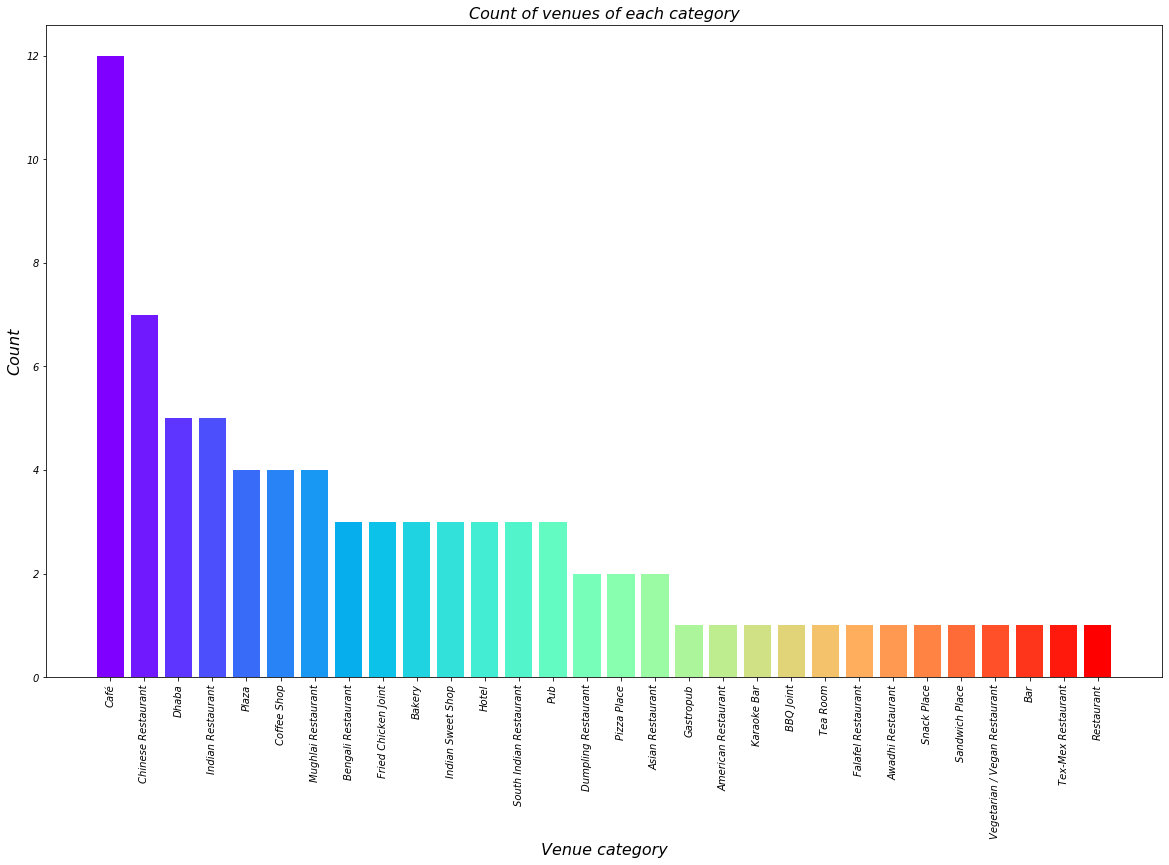

In [23]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

#### Since the rating and price are on different scales, they should be scaled before doing any analysis
will use StandardScaler from SciKitlearn
Get a subset of our features and store in X_train. Let's try to cluster based on:
rating
price

In [24]:
X_train = selected_venues[['rating', 'average_price']].copy()

In [25]:
scaler = StandardScaler()
X_train[['rating', 'average_price']] = scaler.fit_transform(X_train[['rating', 'average_price']])
X_train.head()

,rating,average_price
0,-0.864271,1.137206
1,-0.283309,1.315998
2,0.878616,0.243246
3,0.878616,-0.650715
4,0.297654,-0.829507


#### VIsualize these relationships before plotting

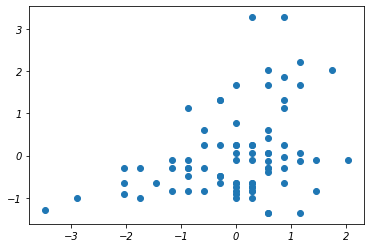

In [26]:
plt.scatter(X_train['rating'], X_train['average_price'])

In [27]:
X_train.corr()

,rating,average_price
rating,1.000000,0.337697
average_price,0.337697,1.000000


## Clustering

First step is to determine how many clusters we should divide the neighbourhoods into. Let's use the visual Elbow method

We'll loop through using 1 to 20 clusters and get the scores in a list

In [28]:
num_clusters = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in num_clusters]

score = [kmeans[i].fit(X_train).score(X_train) for i in range(len(kmeans))]
score

[-162.00000000000003,
 -98.59637748224846,
 -53.23805212598714,
 -40.965230754923866,
 -32.427992832258965,
 -25.61672242494034,
 -21.30199798633293,
 -17.808801930459904,
 -14.251415100961731,
 -12.399758014074077,
 -11.2250513575309,
 -9.87288741466699,
 -9.15237439821316,
 -7.942396897164892,
 -7.363003014696843,
 -7.014642215364848,
 -6.091795493758807,
 -5.723385835231276,
 -5.3249969207837]

Next, plot the score vs the number of clusters and look for the "elbow" where you get diminishing returns

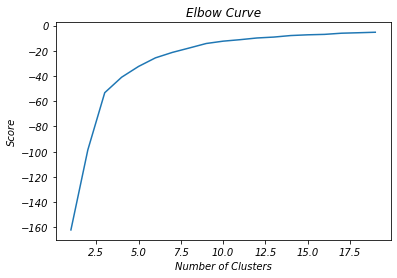

In [29]:
plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()

Looks like the elbow is at 6 clusters, so let's use that and re-run KMeans to get our Clusters

In [30]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X_train)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[20:30]

array([1, 3, 1, 1, 3, 5, 5, 5, 1, 4])

In [31]:
# # add clustering labels back to our original data set
selected_venues['Cluster Labels'] = kmeans.labels_

selected_venues.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price,Cluster Labels
0,Hotel,The Tea Lounge - The Lalit Great Eastern,22.5679,88.3502,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",750.0,4
1,Pub,Blue And Beyond,22.5591,88.3532,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",800.0,4
2,Indian Restaurant,Peter Cat,22.5524,88.3525,3.0,4.3,"18A, Park Street, Park Street Area, Kolkata",500.0,1
3,Asian Restaurant,Blue Poppy-Thakali,22.5486,88.3512,2.0,4.3,"Sikkim Commercial House, 1st Floor, 4/1 Middle...",250.0,1
4,Bakery,Flurys,22.5528,88.3525,1.0,4.1,"18, Park Street Area, Kolkata",200.0,3


In [32]:
# create map to visualize the clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i+x+(i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, venue, address, cluster in zip(selected_venues['latitude'], selected_venues['longitude'], selected_venues['venue'],selected_venues['address'], selected_venues['Cluster Labels']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 1,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_clusters)
       
map_clusters

In [33]:
result = selected_venues[selected_venues['Cluster Labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,categories,venue,latitude,longitude,price_range,rating,address,average_price,Cluster Labels
0,Café,Cafe Coffee Day,22.5154,88.3544,2.0,3.4,"P - 86, Lake Road, Desapriya Park, Kolkata",350.0,0
1,Plaza,Samrat Fast Food Centre,22.5166,88.3661,1.0,3.0,"57/F, Purna Das Road, Near Golpark Signal, Gol...",150.0,0
2,Café,Cafe Coffee Day,22.5878,88.4082,2.0,3.3,"DC 22, Near City Centre, Sector 1, Salt Lake, ...",350.0,0
3,Hotel,Sugarworks - The Sonnet,22.5897,88.4116,1.0,3.3,"The Sonnet, DD 8, Sector 1, Salt Lake",175.0,0
4,Snack Place,Kathleen,22.5161,88.3525,1.0,2.8,"280A, Sarat Bose Road, Desapriya Park, Kolkata",75.0,0
5,South Indian Restaurant,Arnav Dhaba,22.5152,88.3523,2.0,3.3,"203, Sarat Bose Road, Lake Market Area, Kolkata",250.0,0
6,Plaza,Gossip,22.5022,88.3579,1.0,3.4,"Lords Bakery Crossing, Near South City Complex...",150.0,0


In [34]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['average_price'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 214.29 and rating spread around 3.21


In [35]:
result = selected_venues[selected_venues['Cluster Labels'] == 1]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,categories,venue,latitude,longitude,price_range,rating,address,average_price,Cluster Labels
0,Indian Restaurant,Peter Cat,22.5524,88.3525,3.0,4.3,"18A, Park Street, Park Street Area, Kolkata",500.0,1
1,Asian Restaurant,Blue Poppy-Thakali,22.5486,88.3512,2.0,4.3,"Sikkim Commercial House, 1st Floor, 4/1 Middle...",250.0,1
2,Bengali Restaurant,6 Ballygunge Place,22.5276,88.3686,2.0,4.4,"6, Ballygunge Place, Ballygunge, Kolkata",395.0,1
3,Café,Piccadilly Square,22.5381,88.3544,2.0,4.3,"15B, Sarat Bose Road, Elgin, Kolkata",425.0,1
4,Coffee Shop,Starbucks Coffee,22.5523,88.3532,2.0,4.3,"57 A, Ground Floor, Park Mansions, Park Street...",350.0,1
5,Awadhi Restaurant,India Restaurant,22.5389,88.3222,2.0,4.5,"34, Karl Marx Sarani, Kidderpore, Kolkata",400.0,1
6,Café,Mrs. Magpie,22.5163,88.3617,2.0,4.2,"570, Lake Terrace Road Extension, Keyatala, So...",325.0,1
7,Indian Restaurant,Momo I Am,22.5690,88.4334,2.0,4.7,"RBD Cinema, 1st Floor, Sector 5, Salt Lake, Ko...",400.0,1
8,Bengali Restaurant,6 Ballygunge Place,22.5903,88.4092,2.0,4.2,"DD 31A, Sector 1, Salt Lake",395.0,1
9,Coffee Shop,Starbucks Coffee,22.5017,88.3619,2.0,4.2,"375, South City Mall, Prince Anwar Shah Road, ...",350.0,1


In [36]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['average_price'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 379.33 and rating spread around 4.33


In [37]:
selected_venues

,categories,venue,latitude,longitude,price_range,rating,address,average_price,Cluster Labels
0,Hotel,The Tea Lounge - The Lalit Great Eastern,22.5679,88.3502,3.0,3.7,"The Lalit Great Eastern, 1 - 3, Old Court Hous...",750.0,4
1,Pub,Blue And Beyond,22.5591,88.3532,3.0,3.9,"The Lindsay, 8A & 8B, Lindsay Street, New Mark...",800.0,4
2,Indian Restaurant,Peter Cat,22.5524,88.3525,3.0,4.3,"18A, Park Street, Park Street Area, Kolkata",500.0,1
3,Asian Restaurant,Blue Poppy-Thakali,22.5486,88.3512,2.0,4.3,"Sikkim Commercial House, 1st Floor, 4/1 Middle...",250.0,1
4,Bakery,Flurys,22.5528,88.3525,1.0,4.1,"18, Park Street Area, Kolkata",200.0,3
5,BBQ Joint,Flavours Of China,22.5530,88.3526,3.0,4.2,"43, 47, 55, Park Street, Park Street Area, Kol...",600.0,4
6,Restaurant,Don Giovanni's Good Fellas,22.5532,88.3533,2.0,4.1,"57 A, Park Street Area, Kolkata",400.0,4
7,Dhaba,Balwant Singh's Eating House,22.5377,88.3442,2.0,4.0,"10/B, Harish Mukherjee Road, Near Bhawanipur G...",250.0,3
9,Chinese Restaurant,Serafina,22.5389,88.3656,4.0,4.1,"33, 5th Floor, Quest Mall, Syed Ali Amir Avenu...",1350.0,2
10,Dhaba,Jai Hind Dhaba,22.5331,88.3532,1.0,4.1,"41/1A, Sarat Bose Road, Paddapukur, Kolkata",225.0,3
